In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import moscot
from moscot.problems.time import TemporalProblem
import moscot.plotting as mpl

In [3]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_multiVI_embedding.h5ad")

In [4]:
endocrine_celltypes = [
    "Ductal",
    "Prlf. Ductal",
    "Ngn3 low",
    "Ngn3 high",
    "Ngn3 high cycling",
    "Fev+",
    "Fev+ Alpha",
    "Fev+ Beta",
    "Fev+ Delta",
    "Eps/Delta progenitors",
    "Alpha",
    "Beta",
    "Delta",
    "Epsilon"
]

In [5]:
adata_red = adata[adata.obs["celltype"].isin(endocrine_celltypes)]

In [6]:
adata_removed = adata[~adata.obs["celltype"].isin(endocrine_celltypes)]

In [7]:
adata_removed.obs["celltype"].cat.categories

Index(['Imm. Acinar', 'Mat. Acinar'], dtype='object')

In [8]:
adata_red.obs["celltype"].cat.categories

Index(['Alpha', 'Beta', 'Delta', 'Ductal', 'Eps/Delta progenitors', 'Epsilon',
       'Fev+', 'Fev+ Alpha', 'Fev+ Beta', 'Fev+ Delta', 'Ngn3 high',
       'Ngn3 high cycling', 'Ngn3 low', 'Prlf. Ductal'],
      dtype='object')

In [9]:
adata = adata_red.copy()

In [10]:
adata.obs['time'] = adata.obs.apply(lambda x: 14.5 if x["sample"]=="E14.5" else 15.5, axis=1)

In [11]:
sc.tl.umap(adata)

/home/icb/dominik.klein/miniconda3/envs/jax_gpu2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


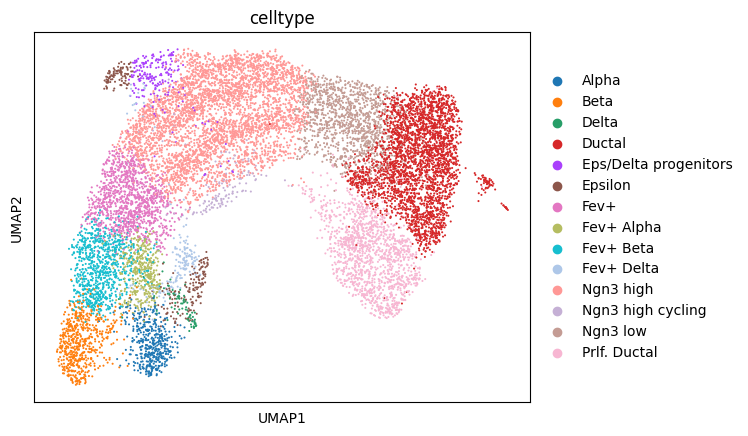

In [12]:
sc.pl.umap(adata, color="celltype")

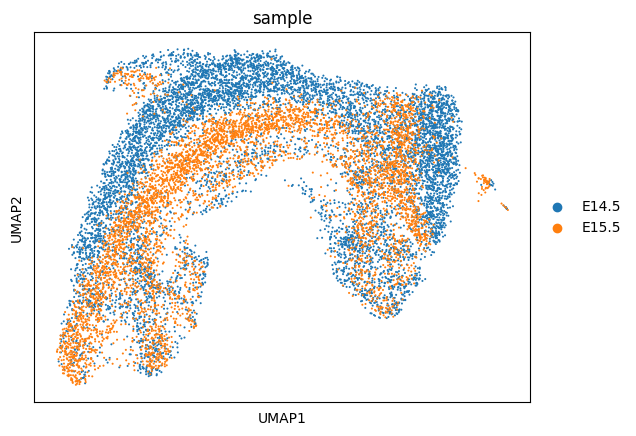

In [13]:
sc.pl.umap(adata, color="sample")

In [14]:
sc.tl.leiden(adata, restrict_to=("celltype", ["Eps/Delta progenitors"]), resolution=0.3, key_added="tmp_1")


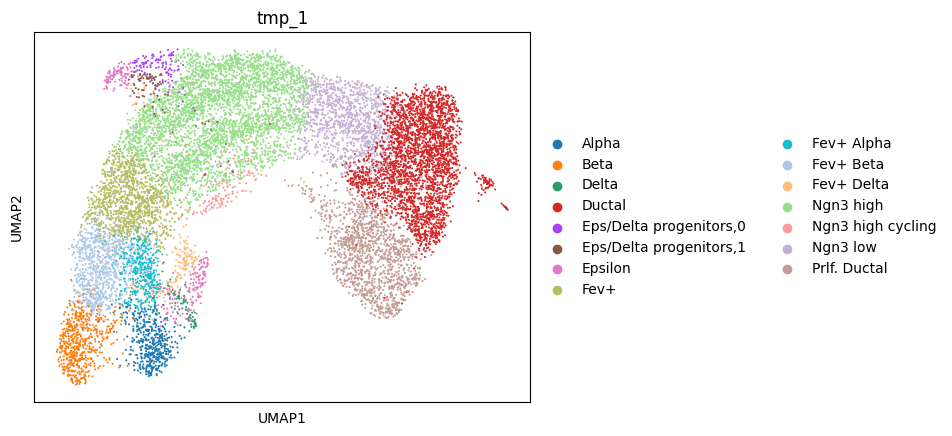

In [15]:
sc.pl.umap(adata, color="tmp_1")

In [16]:
sc.tl.leiden(adata, restrict_to=("tmp_1", ["Ngn3 high"]), resolution=0.5, key_added="tmp_2")


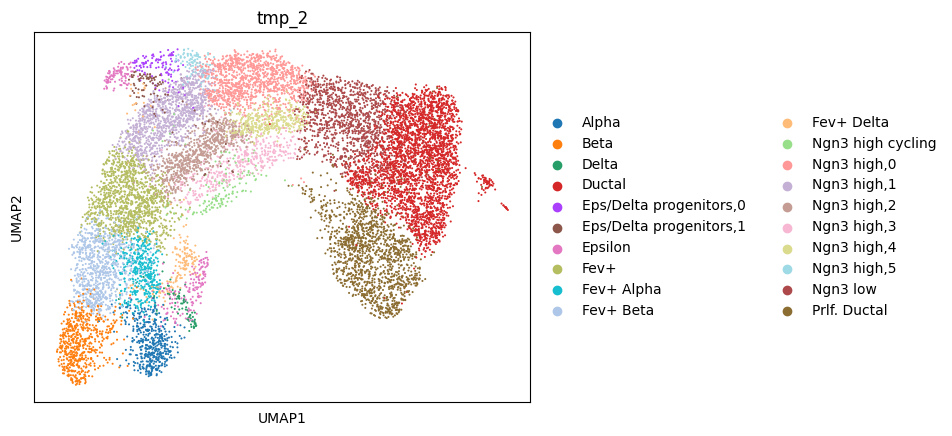

In [17]:
sc.pl.umap(adata, color="tmp_2")

In [18]:
adata.obs["celltype_refined"] = adata.obs["tmp_2"]

In [19]:
x,y = 'sample', 'celltype_refined'
df = adata.obs.copy()
df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

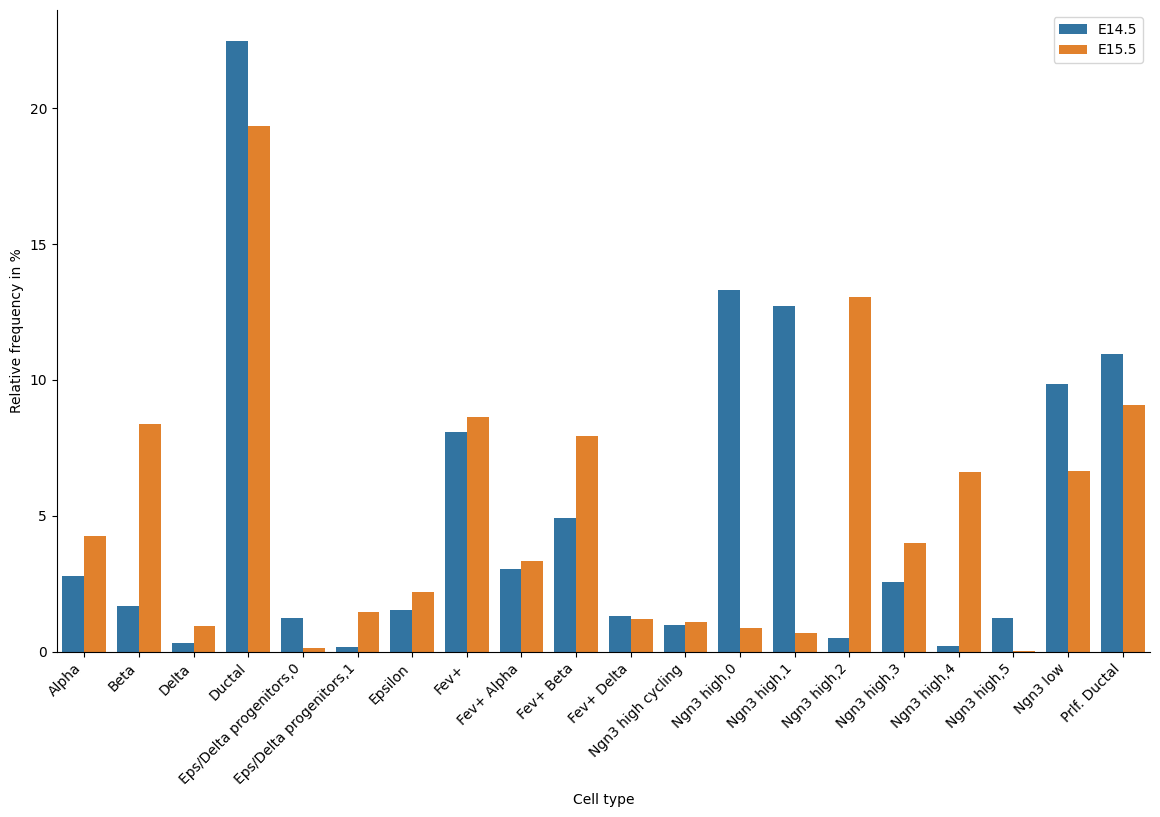

In [20]:
import seaborn as sns

g = sns.catplot(x="level_1",y='percent',hue=x,kind='bar',data=df1, legend=False,height=8.27, aspect=11.7/8.27)
plt.xlabel("Cell type")
plt.ylabel("Relative frequency in %")
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()


# MultiVI space


In [21]:
adata_2 = adata.copy()

In [22]:
ngn3_indices = adata_2[adata_2.obs["celltype"].isin(["Ngn3 high", "Ngn3 low"])].obs.index

In [23]:
to_remove = np.random.choice(ngn3_indices, int(len(ngn3_indices)*2/3), replace=False)

In [24]:
len(to_remove)

3382

In [25]:
adata_2 = adata_2[~adata_2.obs.index.isin(to_remove)]

In [26]:
sc.tl.umap(adata_2)

/home/icb/dominik.klein/miniconda3/envs/jax_gpu2/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


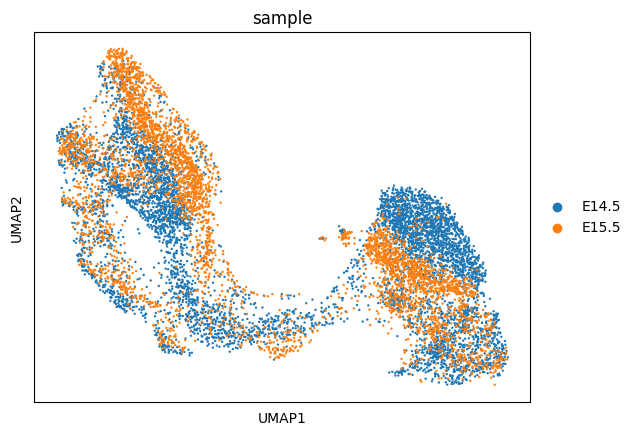

In [27]:
sc.pl.umap(adata_2, color="sample")

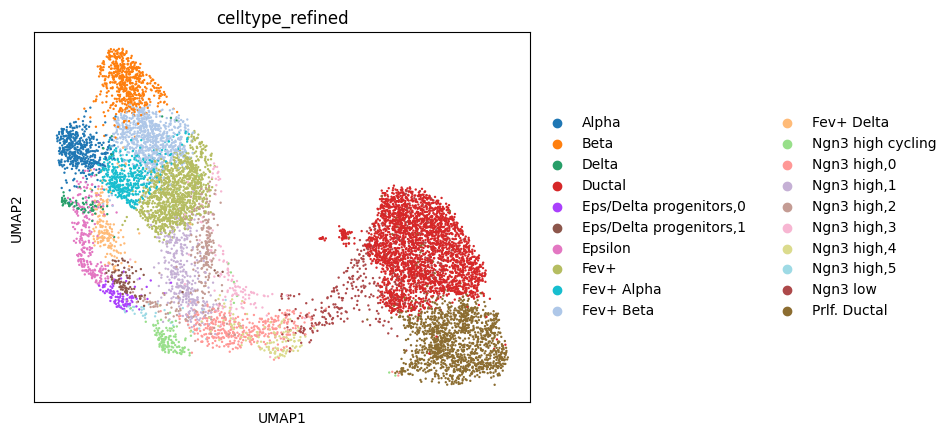

In [28]:
sc.pl.umap(adata_2, color="celltype_refined")

In [29]:
tp0 = TemporalProblem(adata_2)
tp0 = tp0.score_genes_for_marginals(gene_set_proliferation="mouse", gene_set_apoptosis="mouse")
tp0 = tp0.prepare("time", joint_attr="X_multi_vi")

/home/icb/dominik.klein/miniconda3/envs/jax_gpu2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/home/icb/dominik.klein/miniconda3/envs/jax_gpu2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [30]:
tp0 = tp0.solve(epsilon=1e-2, scale_cost="mean", max_iterations=1e5)

/home/icb/dominik.klein/git_repos/moscot/moscot/solvers/_base_solver.py:163: UserWarning: Solver did not converge
  warnings.warn("Solver did not converge")


In [31]:
ct_desc = tp0.cell_transition(start=14.5, end=15.5, early_annotation="celltype_refined", late_annotation="celltype_refined", forward=True)

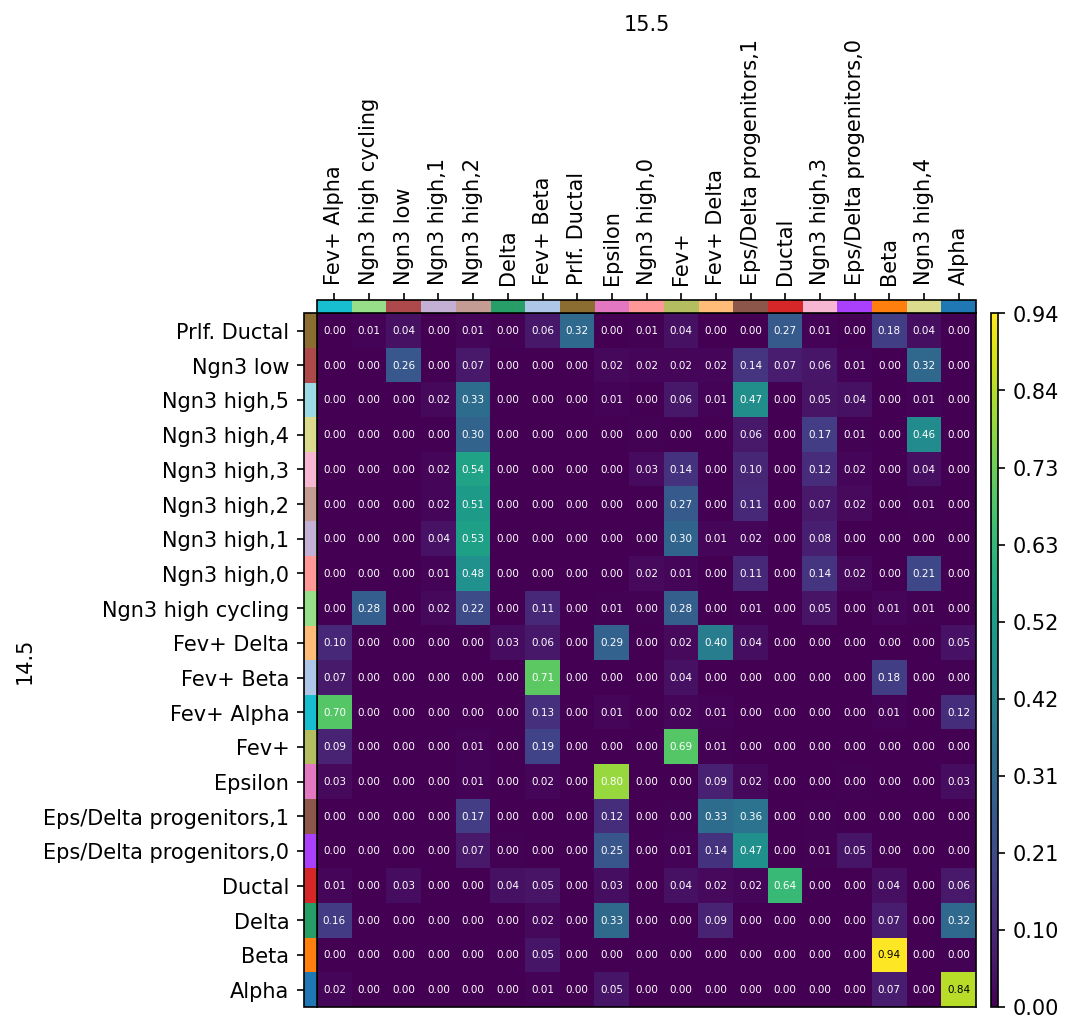

In [32]:
mpl.cell_transition(tp0, dpi=150, fontsize=5)

In [33]:
ct_ans = tp0.cell_transition(start=14.5, end=15.5, early_annotation="celltype_refined", late_annotation="celltype_refined", forward=False)

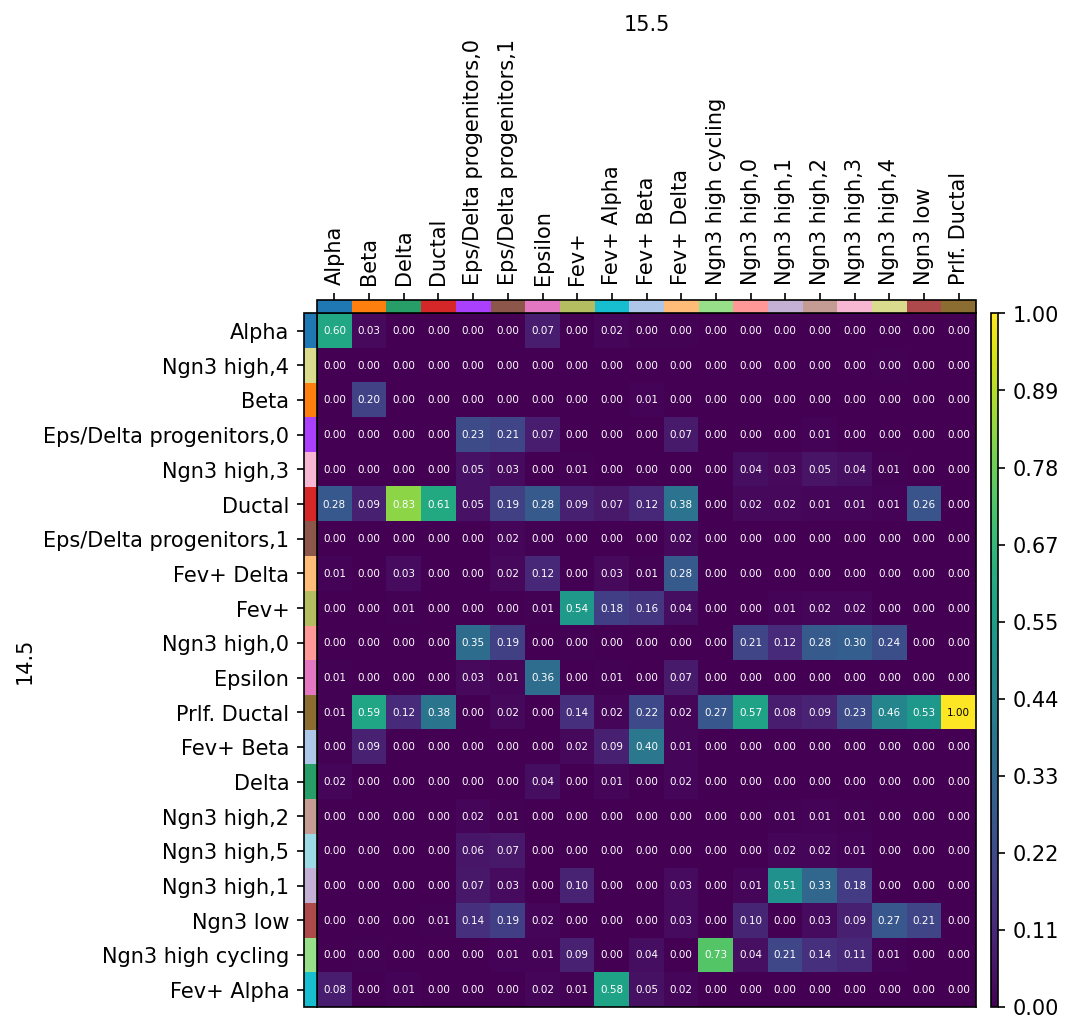

In [34]:
mpl.cell_transition(tp0, dpi=150, fontsize=5)

In [35]:
tp0.pull(14.5, 15.5, data="celltype_refined", subset="Delta", key_added="delta_pull")

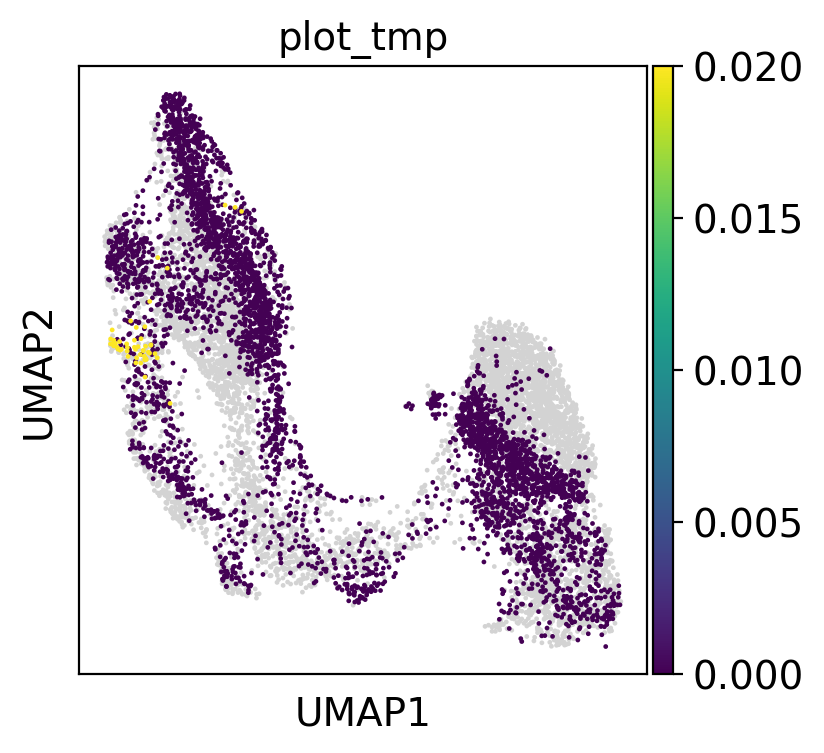

In [37]:
mpl.pull(tp0, time_points=[15.5], key_stored="delta_pull")

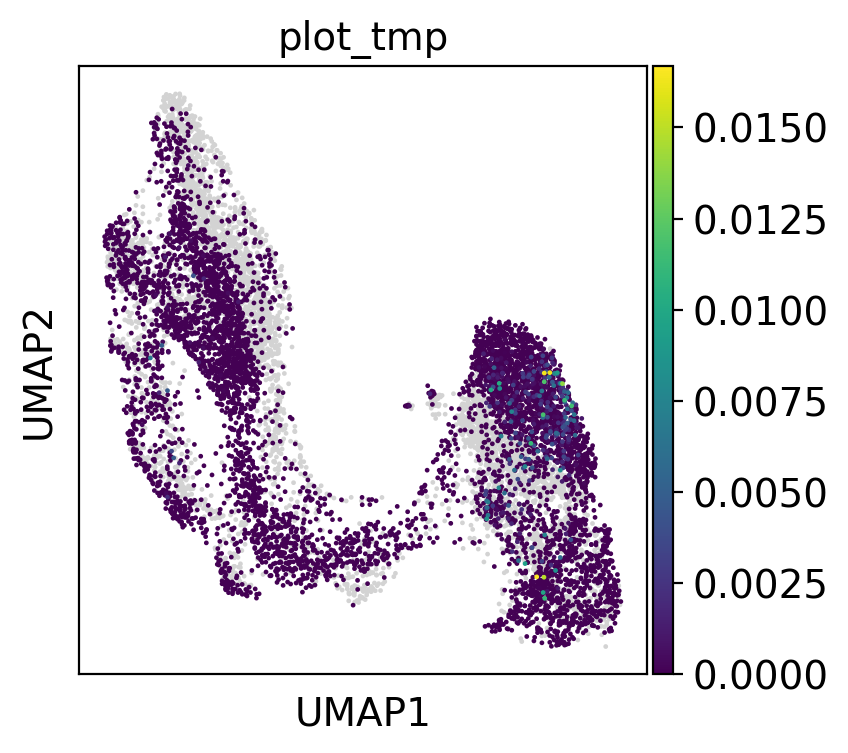

In [38]:
mpl.pull(tp0, time_points=[14.5], key_stored="delta_pull")

In [45]:
adata_2.obs["delta_pull_thresholded"] = adata_2.obs["delta_pull"] > np.percentile(adata_2.obs["delta_pull"], 98)

In [46]:
adata_2.obs["delta_pull_thresholded"] = adata_2.obs["delta_pull_thresholded"].astype(float)

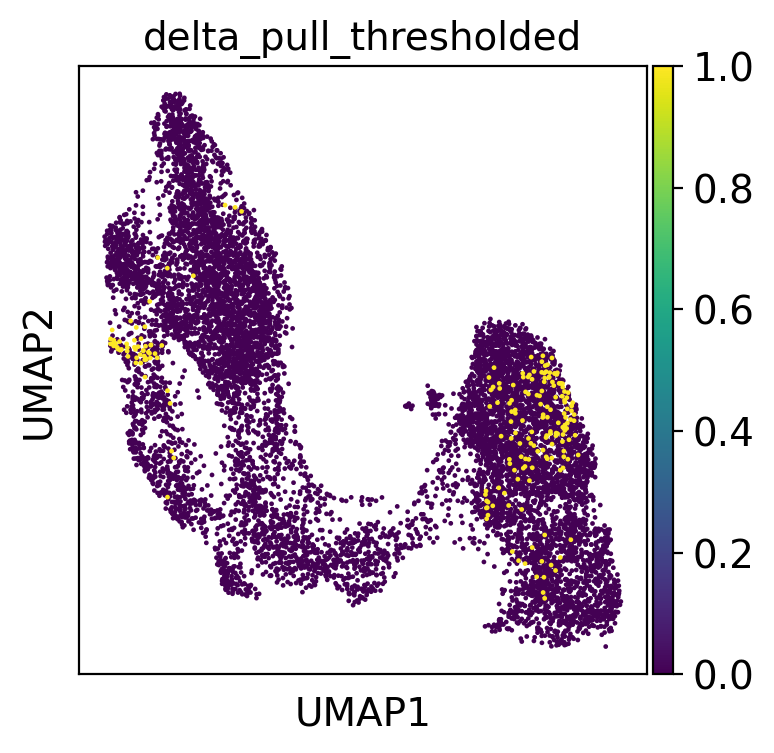

In [47]:
sc.pl.umap(adata_2, color="delta_pull_thresholded")

In [51]:
adata_2.uns['iroot'] = np.flatnonzero(adata_2.obs['celltype'] == 'Prlf. Ductal')[0]

In [52]:
sc.tl.dpt(adata_2)

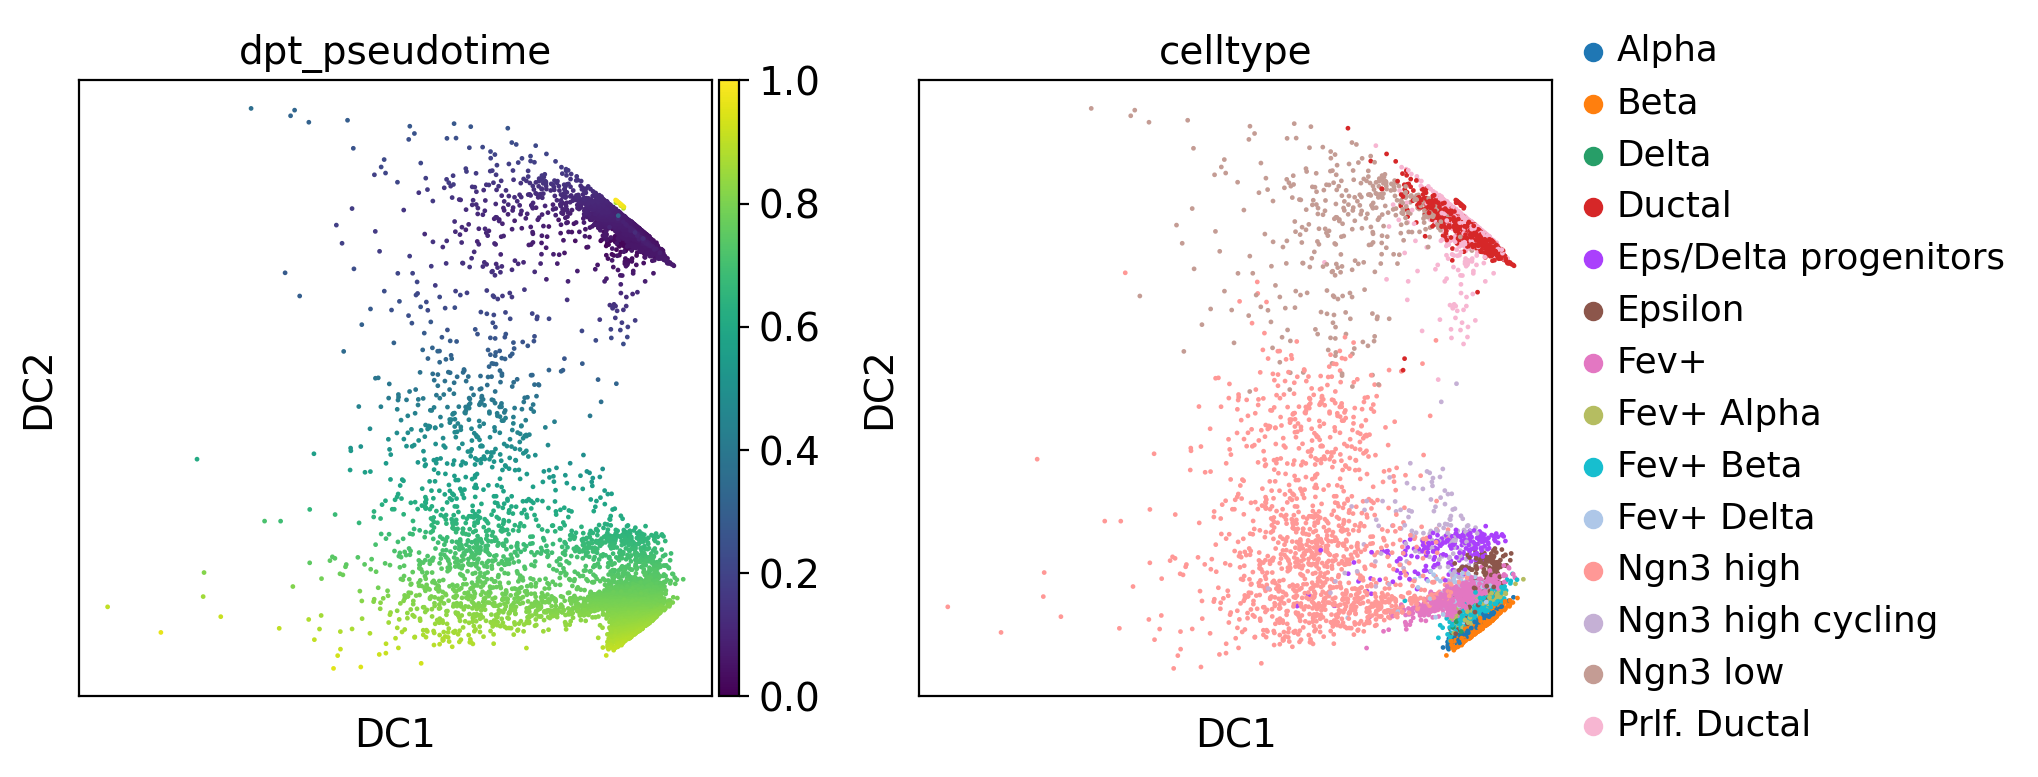

In [56]:
sc.pl.diffmap(adata_2, color=['dpt_pseudotime', 'celltype'])

In [57]:
adata_3 = adata[adata.obs["celltype"] != "Prlf. Ductal"].copy()

In [58]:
adata_3.uns['iroot'] = np.flatnonzero(adata_3.obs['celltype'] == 'Ductal')[0]

In [59]:
sc.tl.dpt(adata_3)

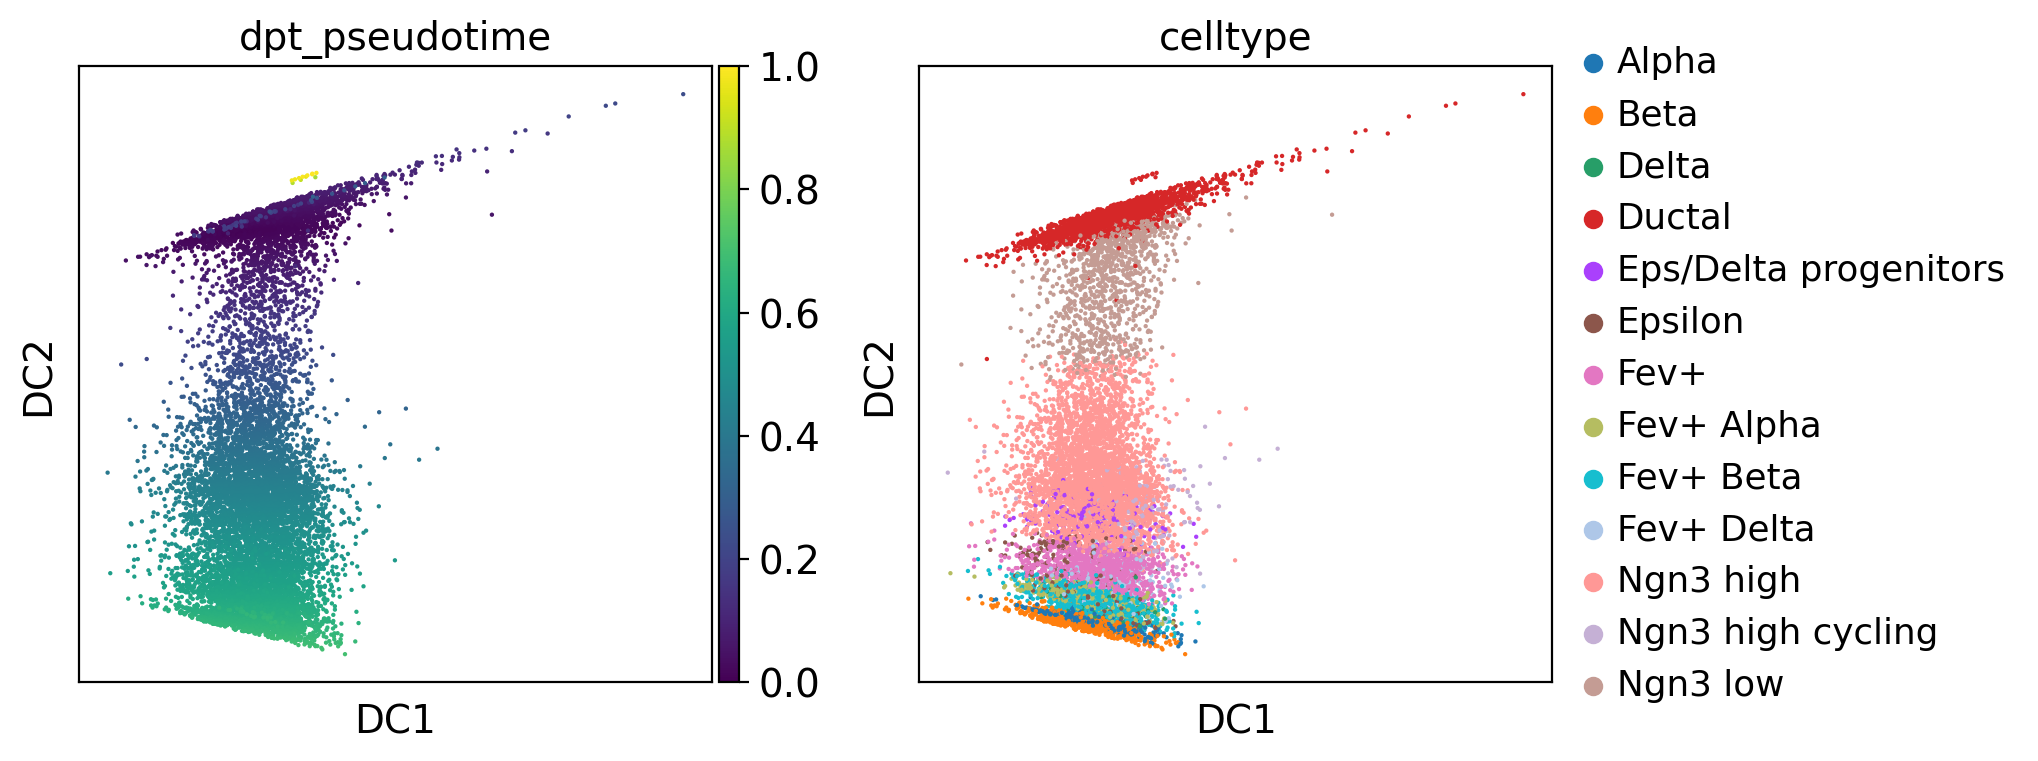

In [60]:
sc.pl.diffmap(adata_3, color=['dpt_pseudotime', 'celltype'])

In [64]:
adata_4 = adata_3[~adata_3.obs["celltype"].isin(["Fev+", "Fev+ Beta", "Ngn3 high cycling"])].copy()

In [65]:
sc.tl.umap(adata_4)

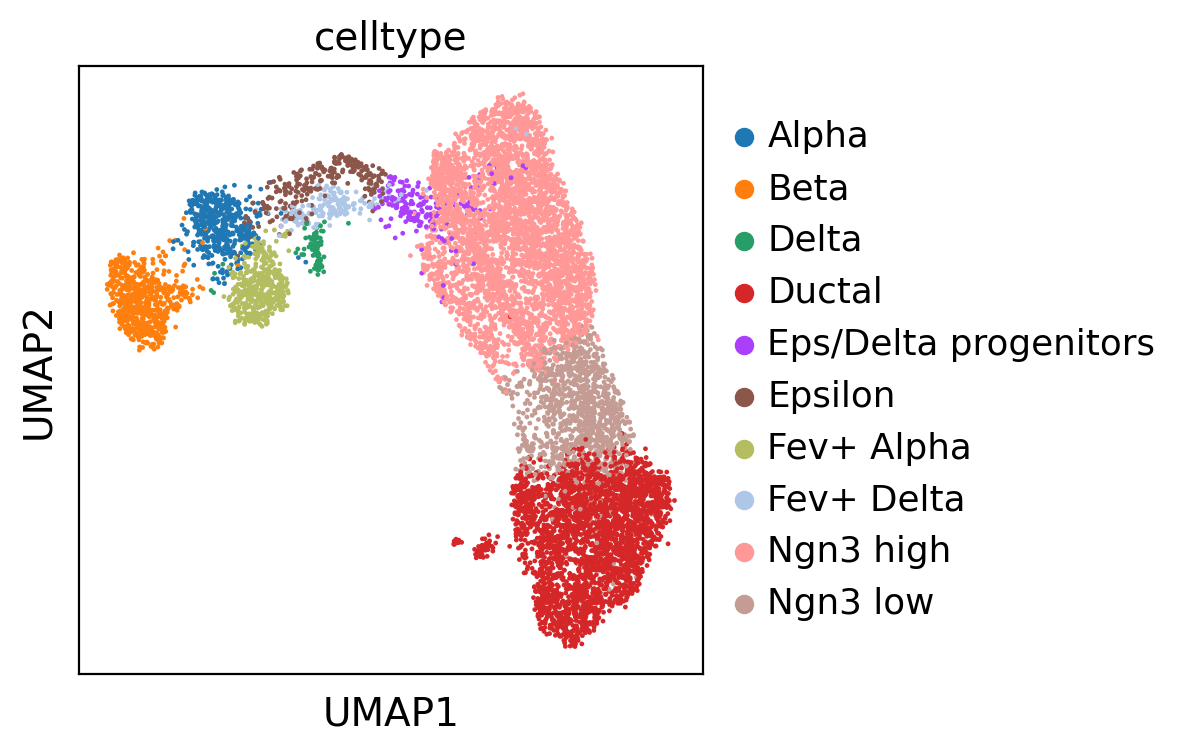

In [66]:
sc.pl.umap(adata_4, color="celltype")

In [67]:
adata_5 = adata_4[~adata_4.obs["celltype"].isin(["Ngn3 high"])].copy()

In [68]:
sc.tl.umap(adata_5)

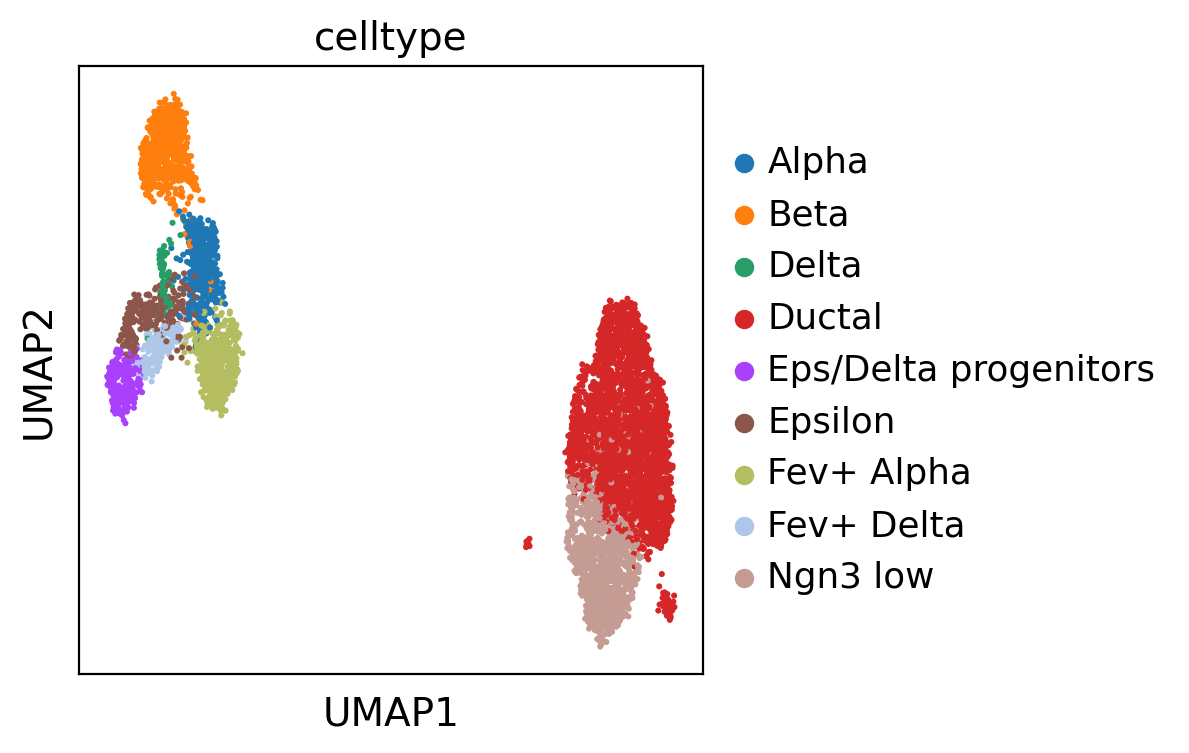

In [70]:
sc.pl.umap(adata_5, color="celltype")

# Back to larger adata

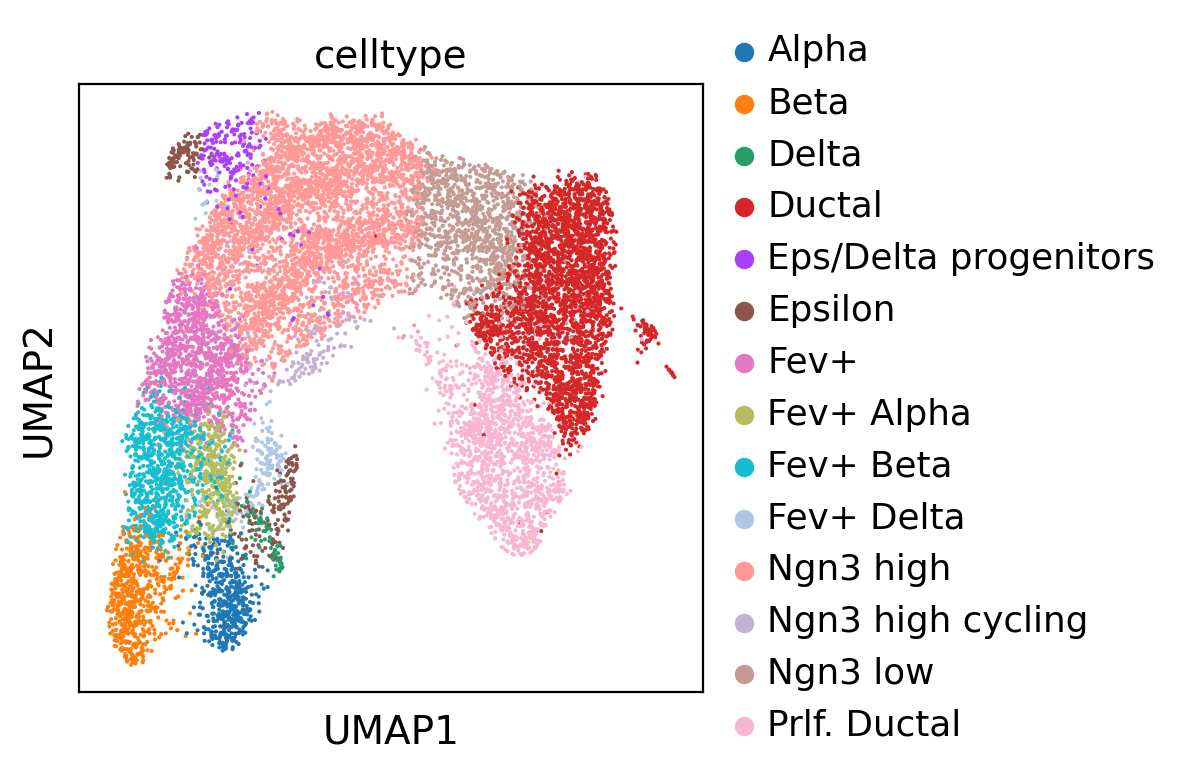

In [72]:
sc.pl.umap(adata, color="celltype")

In [80]:
sc.tl.leiden(adata, restrict_to=("celltype", ["Ductal"]), resolution=0.5, key_added="tmp_2")

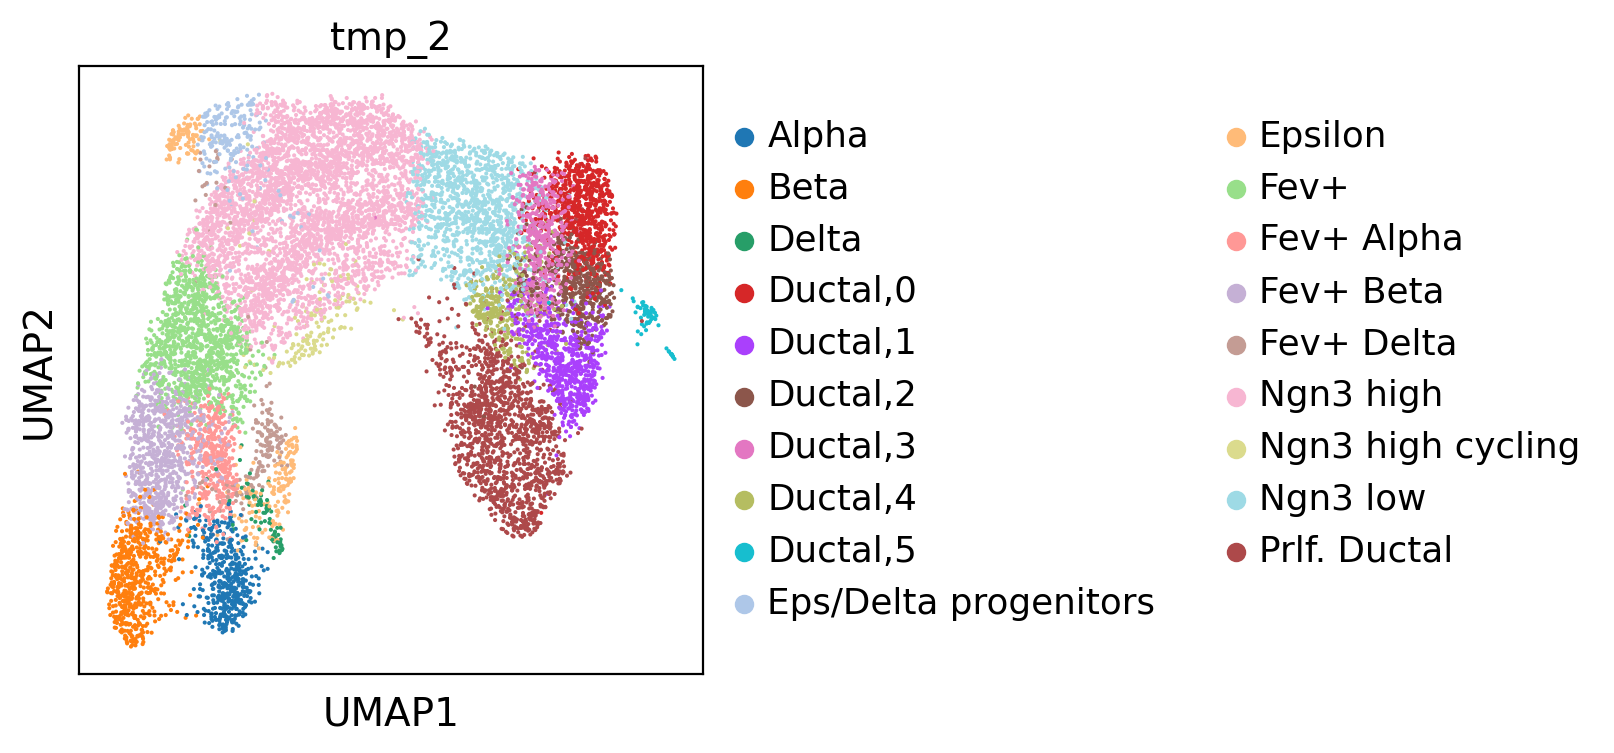

In [81]:
sc.pl.umap(adata, color="tmp_2")

In [82]:
sc.tl.leiden(adata, restrict_to=("celltype", ["Ductal"]), resolution=1, key_added="tmp_3")

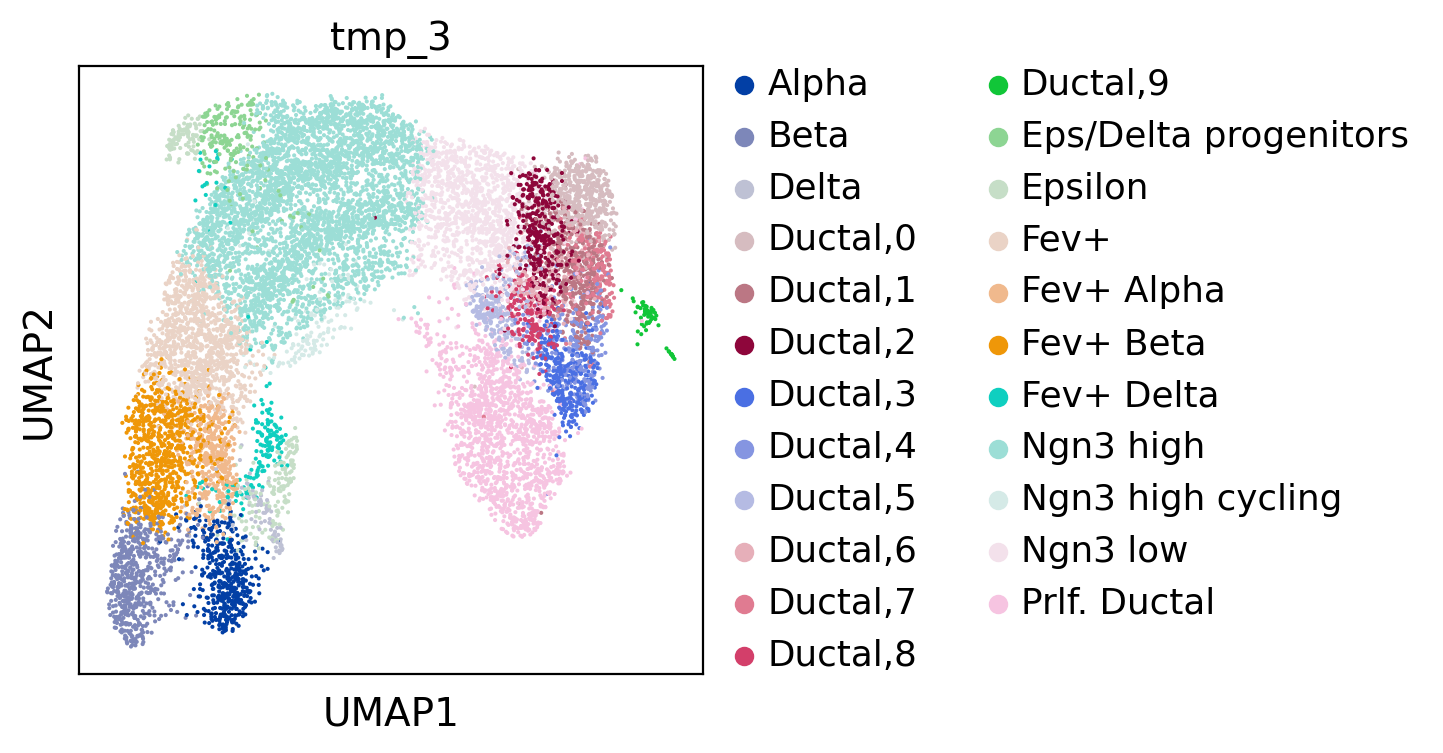

In [83]:
sc.pl.umap(adata, color="tmp_3")

In [76]:
_ = tp0.cell_transition(start=14.5, end=15.5, early_annotation="tmp_2", late_annotation="tmp_2", forward=False)

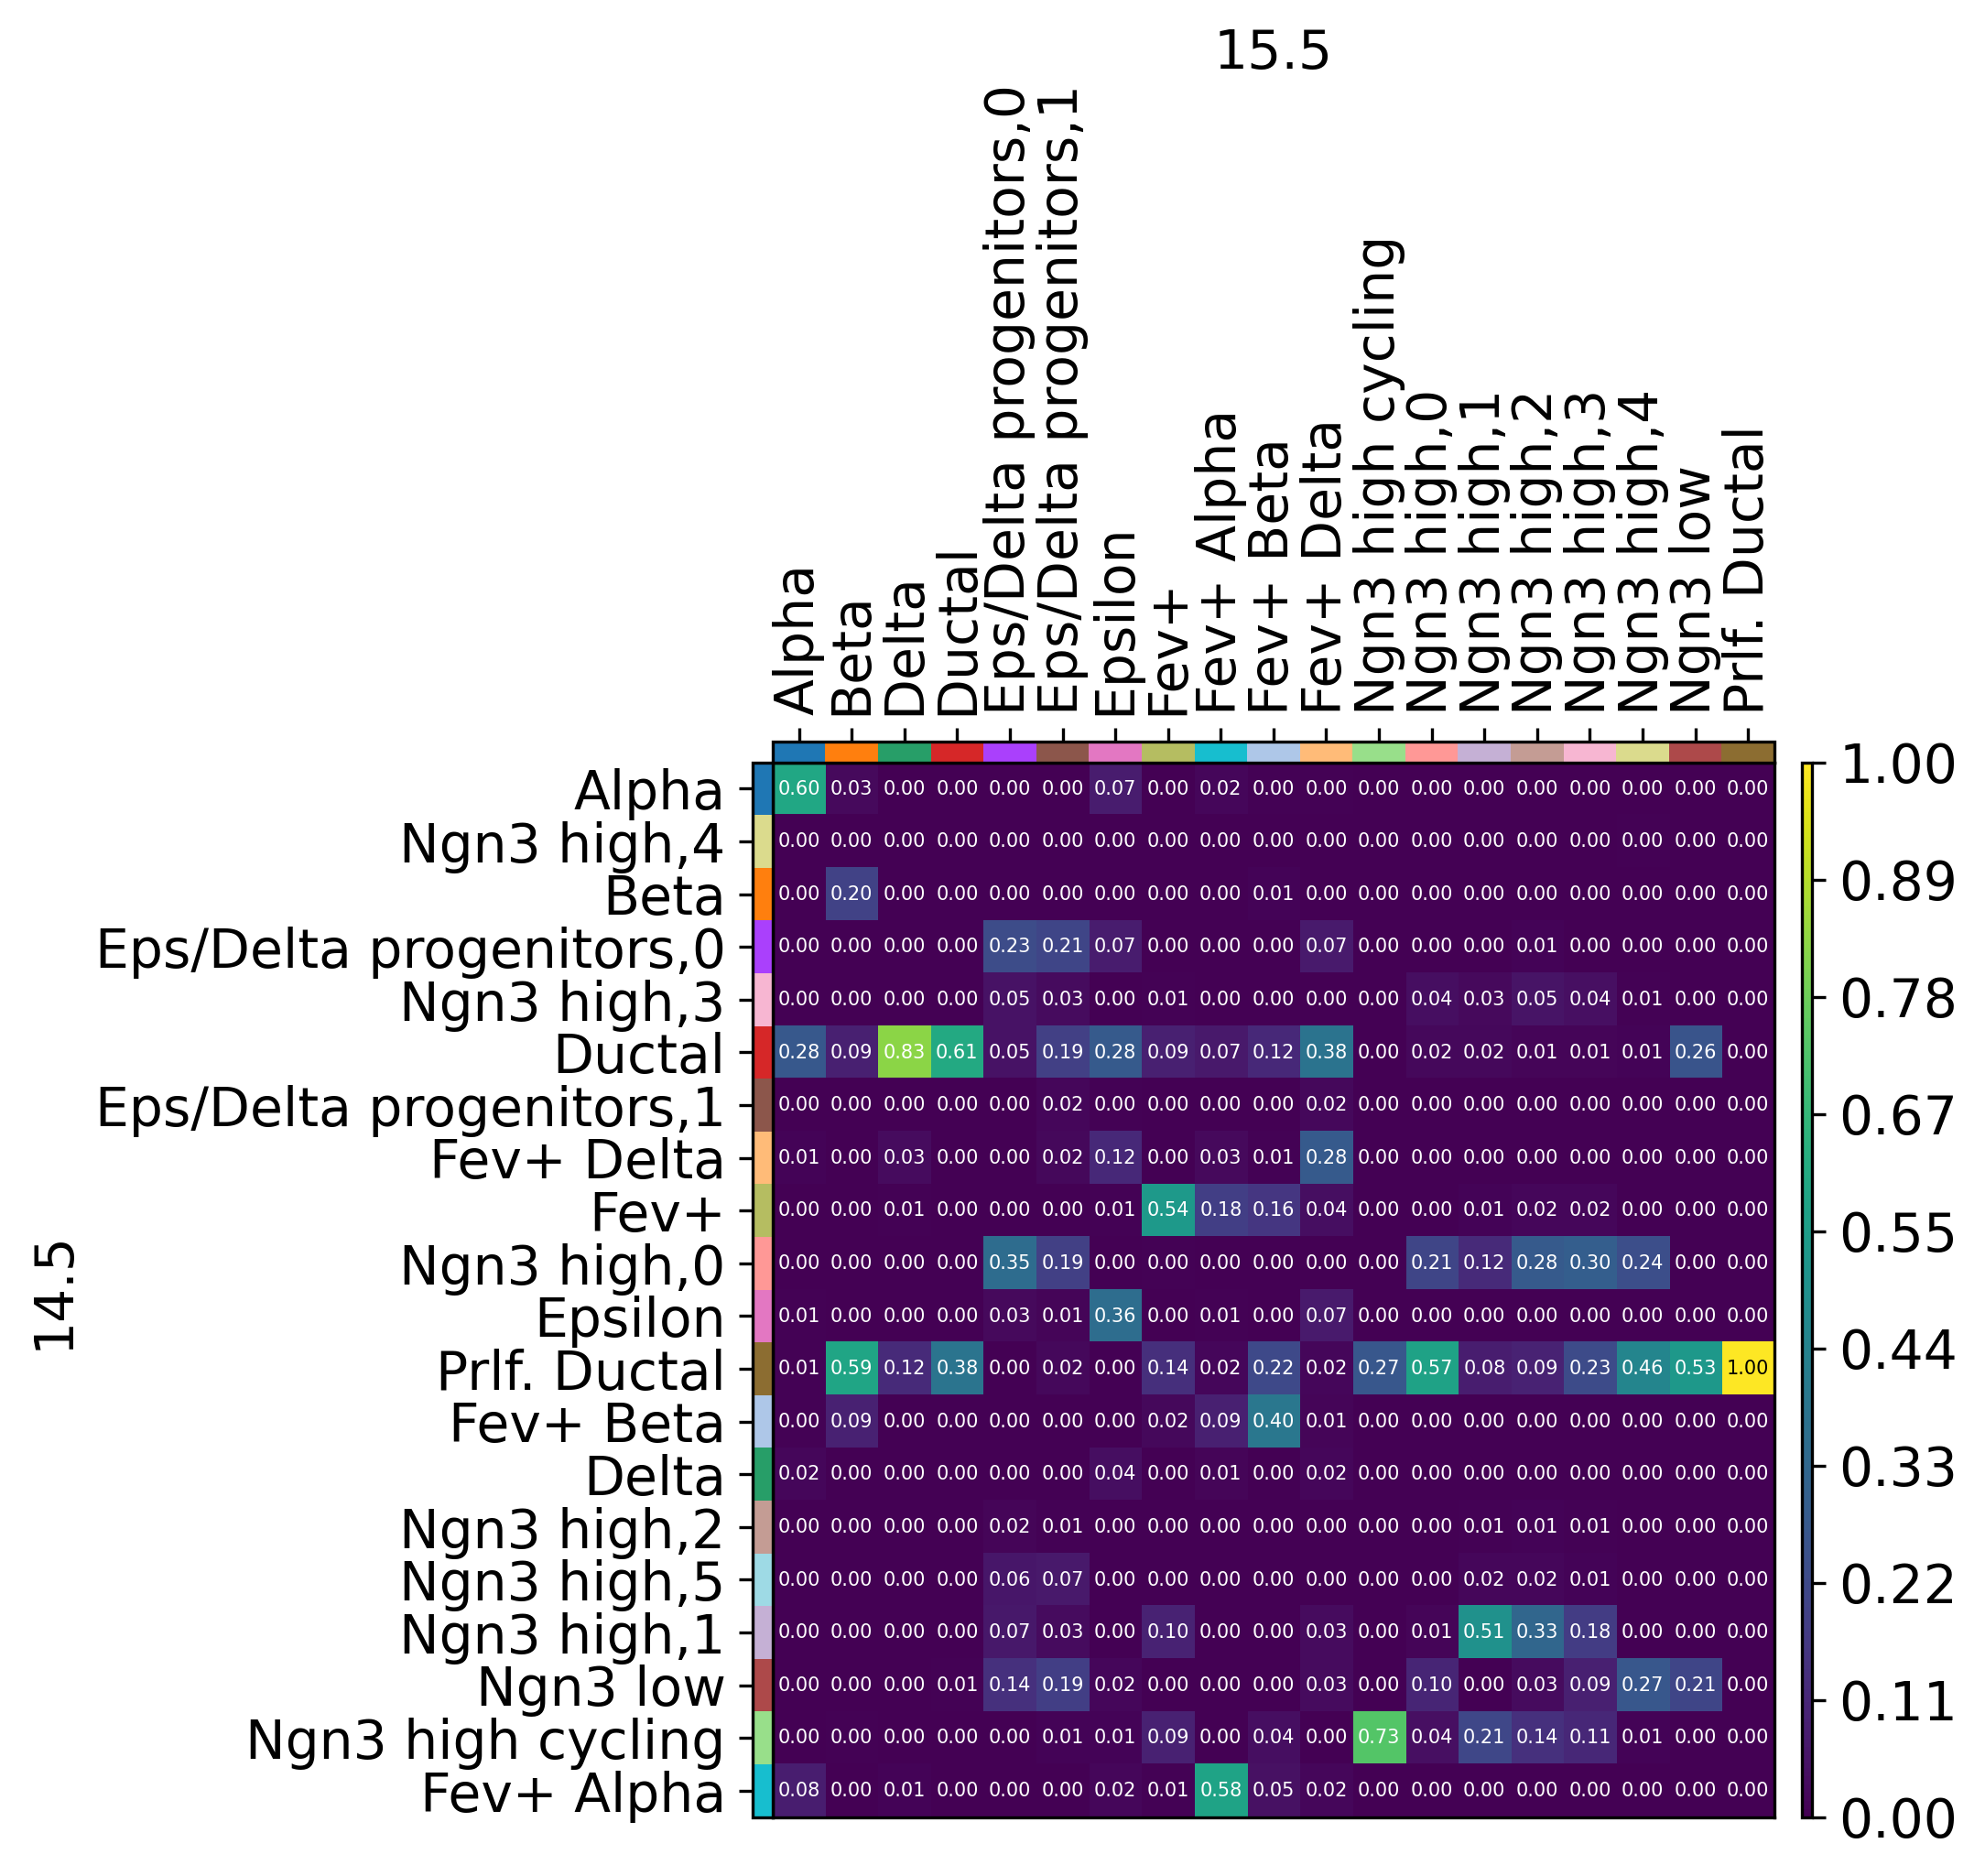

In [77]:
mpl.cell_transition(tp0, dpi=150, fontsize=5)

In [ ]:
tp0 = TemporalProblem(adata)
tp0 = tp0.score_genes_for_marginals(gene_set_proliferation="mouse", gene_set_apoptosis="mouse")
tp0 = tp0.prepare("time", joint_attr="X_multi_vi")